In [0]:
import pandas as pd
import re


Saving LabelledData (1).txt to LabelledData (1).txt
User uploaded file "LabelledData (1).txt" with length 88183 bytes


In [67]:
df = pd.read_csv("LabelledData (1).txt",sep=",,,",header=None ,names=['question','type'])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [0]:
#Data Cleaning
import HTMLParser
df['type']=df['type'].str.strip()
html_parser = HTMLParser.HTMLParser()

# df['question'] = df['question'].apply(lambda x: html_parser.unescape(x))
# df['question'] = df['question'].apply(lambda x: x.encode('ascii','ignore'))

# df['question'] = df['question'].apply(lambda x: x.lower())
# df['question'] = df['question'].apply(lambda x: x.replace(":",' : '))
# df['question'] = df['question'].apply(lambda x: x.replace("!",'. '))
df['question'] = df['question'].apply(lambda x: re.sub('[^a-z0-9\s]','',x))
df['question'] = df['question'].apply(lambda x: "".join(x.strip()))
# df.append([df[df.type=='when']]*5,ignore_index=True)
# df.append([df[df.type=='affirmation']]*5,ignore_index=True)
# df.append([df[df.type=='unknown']]*2,ignore_index=True)

In [0]:

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [0]:
MAX_NB_WORDS = 16384
MAX_SEQUENCE_LENGTH=24

In [0]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, split=' ')
tokenizer.fit_on_texts(df['question'].values)
X = tokenizer.texts_to_sequences(df['question'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [73]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Y = df['type']
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Y)
Y=le.transform(Y) 
labels = to_categorical(np.asarray(Y))
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', labels.shape)

x_train, x_val, y_train, y_val = train_test_split(X, labels, test_size = 0.2)

Found 3685 unique tokens.
('Shape of data tensor:', (1483, 24))
('Shape of label tensor:', (1483, 5))


In [12]:
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip

--2018-05-10 07:26:25--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2018-05-10 07:26:25--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Saving to: ‘glove.42B.300d.zip.1’

glove.42B.300d.zip.  22%[===>                ] 406.85M  6.97MB/s    eta 2m 6s  glove.42B.300d.zip. 100%[===================>]   1.75G  8.28MB/s    in 2m 40s  

2018-05-10 07:29:05 (11.2 MB/s) - ‘glove.42B.300d.zip.1’ saved [1877800501/1877800501]



In [0]:
import zipfile
zip_ref = zipfile.ZipFile('glove.42B.300d.zip.1', 'r')
zip_ref.extractall()
zip_ref.close()

In [74]:
embeddings_index = {}

f = open('glove.42B.300d.txt')
for line in f:
    #print line
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1917494 word vectors.


In [97]:
emb_dimension=300

print('Found %s word vectors.' % len(embeddings_index))

Found 1917494 word vectors.


In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, emb_dimension))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            emb_dimension,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [0]:
from keras.callbacks import History 
from keras import regularizers
from keras import optimizers
history = History()
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(256, dropout=0.4, recurrent_dropout=0.4, activation='relu',kernel_regularizer=regularizers.l2(0.001)))#,activity_regularizer=regularizers.l1(0.01)))

#model.add(LSTM(256, dropout_U=0.5, dropout_W=0.5, activation='relu', kernel_regularizer=l2_reg))
model.add(Dense(5,activation='softmax'))#,kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
rmsprop = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999,)
model.compile(loss = 'categorical_crossentropy', optimizer=rmsprop,metrics = ['accuracy'])

In [132]:
history=model.fit(x_train, y_train,
          batch_size=1186,
          epochs=5000,
          verbose=1,
          validation_data=(x_val, y_val))

Train on 1186 samples, validate on 297 samples
Epoch 1/5000
1186/1186 [==============================] - 4s 3ms/step - loss: 2.1137 - acc: 0.1788 - val_loss: 2.0944 - val_acc: 0.1818
Epoch 2/5000
1186/1186 [==============================] - 0s 169us/step - loss: 2.0999 - acc: 0.1906 - val_loss: 2.0807 - val_acc: 0.1953
Epoch 3/5000
1186/1186 [==============================] - 0s 150us/step - loss: 2.0855 - acc: 0.1863 - val_loss: 2.0666 - val_acc: 0.2054
Epoch 4/5000
1186/1186 [==============================] - 0s 139us/step - loss: 2.0646 - acc: 0.2260 - val_loss: 2.0524 - val_acc: 0.2020
Epoch 5/5000
1186/1186 [==============================] - 0s 133us/step - loss: 2.0545 - acc: 0.2251 - val_loss: 2.0382 - val_acc: 0.2525
Epoch 6/5000
1186/1186 [==============================] - 0s 131us/step - loss: 2.0352 - acc: 0.2563 - val_loss: 2.0242 - val_acc: 0.3199
Epoch 7/5000
1186/1186 [==============================] - 0s 129us/step - loss: 2.0215 - acc: 0.2901 - val_loss: 2.0104 - val_a

1186/1186 [==============================] - 0s 130us/step - loss: 1.5030 - acc: 0.5868 - val_loss: 1.4796 - val_acc: 0.6229
Epoch 80/5000
1186/1186 [==============================] - 0s 131us/step - loss: 1.4960 - acc: 0.5885 - val_loss: 1.4712 - val_acc: 0.6330
Epoch 81/5000
1186/1186 [==============================] - 0s 133us/step - loss: 1.4939 - acc: 0.5927 - val_loss: 1.4631 - val_acc: 0.6330
Epoch 82/5000
1186/1186 [==============================] - 0s 133us/step - loss: 1.4748 - acc: 0.6037 - val_loss: 1.4546 - val_acc: 0.6397
Epoch 83/5000
1186/1186 [==============================] - 0s 132us/step - loss: 1.4618 - acc: 0.6037 - val_loss: 1.4455 - val_acc: 0.6498
Epoch 84/5000
1186/1186 [==============================] - 0s 129us/step - loss: 1.4572 - acc: 0.6003 - val_loss: 1.4354 - val_acc: 0.6498
Epoch 85/5000
1186/1186 [==============================] - 0s 129us/step - loss: 1.4533 - acc: 0.6046 - val_loss: 1.4252 - val_acc: 0.6566
Epoch 86/5000
1186/1186 [================

1186/1186 [==============================] - 0s 132us/step - loss: 0.9454 - acc: 0.8153 - val_loss: 0.8042 - val_acc: 0.8586
Epoch 158/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.9295 - acc: 0.8153 - val_loss: 0.8019 - val_acc: 0.8620
Epoch 159/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.9117 - acc: 0.8179 - val_loss: 0.7991 - val_acc: 0.8687
Epoch 160/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.8835 - acc: 0.8212 - val_loss: 0.7955 - val_acc: 0.8687
Epoch 161/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.9262 - acc: 0.8187 - val_loss: 0.7934 - val_acc: 0.8721
Epoch 162/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.9110 - acc: 0.8120 - val_loss: 0.7906 - val_acc: 0.8754
Epoch 163/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.9000 - acc: 0.8229 - val_loss: 0.7860 - val_acc: 0.8754
Epoch 164/5000
1186/1186 [=========

1186/1186 [==============================] - 0s 134us/step - loss: 0.6867 - acc: 0.9022 - val_loss: 0.5645 - val_acc: 0.9428
Epoch 236/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.6579 - acc: 0.9047 - val_loss: 0.5626 - val_acc: 0.9428
Epoch 237/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.6684 - acc: 0.9089 - val_loss: 0.5605 - val_acc: 0.9461
Epoch 238/5000
1186/1186 [==============================] - 0s 128us/step - loss: 0.6733 - acc: 0.9115 - val_loss: 0.5578 - val_acc: 0.9461
Epoch 239/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.6817 - acc: 0.9047 - val_loss: 0.5559 - val_acc: 0.9461
Epoch 240/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.6646 - acc: 0.9056 - val_loss: 0.5535 - val_acc: 0.9461
Epoch 241/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.6472 - acc: 0.9148 - val_loss: 0.5509 - val_acc: 0.9461
Epoch 242/5000
1186/1186 [=========

1186/1186 [==============================] - 0s 131us/step - loss: 0.5079 - acc: 0.9393 - val_loss: 0.4375 - val_acc: 0.9731
Epoch 314/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.4984 - acc: 0.9511 - val_loss: 0.4363 - val_acc: 0.9731
Epoch 315/5000
1186/1186 [==============================] - 0s 137us/step - loss: 0.5025 - acc: 0.9452 - val_loss: 0.4352 - val_acc: 0.9731
Epoch 316/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.5105 - acc: 0.9494 - val_loss: 0.4341 - val_acc: 0.9731
Epoch 317/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.5224 - acc: 0.9553 - val_loss: 0.4331 - val_acc: 0.9731
Epoch 318/5000
1186/1186 [==============================] - 0s 128us/step - loss: 0.5167 - acc: 0.9460 - val_loss: 0.4319 - val_acc: 0.9731
Epoch 319/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.5036 - acc: 0.9469 - val_loss: 0.4306 - val_acc: 0.9731
Epoch 320/5000
1186/1186 [=========

1186/1186 [==============================] - 0s 132us/step - loss: 0.4083 - acc: 0.9637 - val_loss: 0.3601 - val_acc: 0.9731
Epoch 392/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.4163 - acc: 0.9696 - val_loss: 0.3587 - val_acc: 0.9731
Epoch 393/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.4174 - acc: 0.9696 - val_loss: 0.3574 - val_acc: 0.9731
Epoch 394/5000
1186/1186 [==============================] - 0s 135us/step - loss: 0.3989 - acc: 0.9663 - val_loss: 0.3563 - val_acc: 0.9731
Epoch 395/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.4171 - acc: 0.9680 - val_loss: 0.3553 - val_acc: 0.9731
Epoch 396/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.4051 - acc: 0.9680 - val_loss: 0.3545 - val_acc: 0.9731
Epoch 397/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.3898 - acc: 0.9671 - val_loss: 0.3535 - val_acc: 0.9697
Epoch 398/5000
1186/1186 [=========

1186/1186 [==============================] - 0s 130us/step - loss: 0.3390 - acc: 0.9789 - val_loss: 0.3152 - val_acc: 0.9731
Epoch 470/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.3503 - acc: 0.9747 - val_loss: 0.3144 - val_acc: 0.9731
Epoch 471/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.3457 - acc: 0.9739 - val_loss: 0.3136 - val_acc: 0.9731
Epoch 472/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.3570 - acc: 0.9739 - val_loss: 0.3128 - val_acc: 0.9731
Epoch 473/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.3338 - acc: 0.9730 - val_loss: 0.3123 - val_acc: 0.9731
Epoch 474/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.3286 - acc: 0.9798 - val_loss: 0.3116 - val_acc: 0.9731
Epoch 475/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.3539 - acc: 0.9696 - val_loss: 0.3112 - val_acc: 0.9731
Epoch 476/5000
1186/1186 [=========

1186/1186 [==============================] - 0s 133us/step - loss: 0.3012 - acc: 0.9831 - val_loss: 0.2813 - val_acc: 0.9865
Epoch 548/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.2965 - acc: 0.9806 - val_loss: 0.2811 - val_acc: 0.9865
Epoch 549/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.2932 - acc: 0.9781 - val_loss: 0.2808 - val_acc: 0.9865
Epoch 550/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.3082 - acc: 0.9764 - val_loss: 0.2805 - val_acc: 0.9865
Epoch 551/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.2943 - acc: 0.9781 - val_loss: 0.2802 - val_acc: 0.9865
Epoch 552/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.2922 - acc: 0.9730 - val_loss: 0.2798 - val_acc: 0.9865
Epoch 553/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.2976 - acc: 0.9781 - val_loss: 0.2794 - val_acc: 0.9865
Epoch 554/5000
1186/1186 [=========

1186/1186 [==============================] - 0s 132us/step - loss: 0.2697 - acc: 0.9815 - val_loss: 0.2571 - val_acc: 0.9865
Epoch 626/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.2725 - acc: 0.9823 - val_loss: 0.2567 - val_acc: 0.9865
Epoch 627/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.2724 - acc: 0.9798 - val_loss: 0.2564 - val_acc: 0.9865
Epoch 628/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.2724 - acc: 0.9831 - val_loss: 0.2561 - val_acc: 0.9865
Epoch 629/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.2674 - acc: 0.9831 - val_loss: 0.2558 - val_acc: 0.9865
Epoch 630/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.2557 - acc: 0.9857 - val_loss: 0.2555 - val_acc: 0.9865
Epoch 631/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.2483 - acc: 0.9890 - val_loss: 0.2550 - val_acc: 0.9865
Epoch 632/5000
1186/1186 [=========

1186/1186 [==============================] - 0s 135us/step - loss: 0.2330 - acc: 0.9874 - val_loss: 0.2395 - val_acc: 0.9865
Epoch 704/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.2397 - acc: 0.9831 - val_loss: 0.2394 - val_acc: 0.9865
Epoch 705/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.2332 - acc: 0.9815 - val_loss: 0.2393 - val_acc: 0.9865
Epoch 706/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.2404 - acc: 0.9848 - val_loss: 0.2389 - val_acc: 0.9865
Epoch 707/5000
1186/1186 [==============================] - 0s 135us/step - loss: 0.2406 - acc: 0.9781 - val_loss: 0.2386 - val_acc: 0.9865
Epoch 708/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.2298 - acc: 0.9874 - val_loss: 0.2380 - val_acc: 0.9865
Epoch 709/5000
1186/1186 [==============================] - 0s 139us/step - loss: 0.2438 - acc: 0.9806 - val_loss: 0.2376 - val_acc: 0.9865
Epoch 710/5000
1186/1186 [=========

1186/1186 [==============================] - 0s 133us/step - loss: 0.2247 - acc: 0.9823 - val_loss: 0.2213 - val_acc: 0.9865
Epoch 782/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.2143 - acc: 0.9831 - val_loss: 0.2215 - val_acc: 0.9865
Epoch 783/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.2227 - acc: 0.9865 - val_loss: 0.2214 - val_acc: 0.9865
Epoch 784/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.2124 - acc: 0.9865 - val_loss: 0.2214 - val_acc: 0.9832
Epoch 785/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.2220 - acc: 0.9865 - val_loss: 0.2214 - val_acc: 0.9832
Epoch 786/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.2105 - acc: 0.9874 - val_loss: 0.2213 - val_acc: 0.9832
Epoch 787/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.2134 - acc: 0.9831 - val_loss: 0.2211 - val_acc: 0.9865
Epoch 788/5000
1186/1186 [=========

1186/1186 [==============================] - 0s 138us/step - loss: 0.1998 - acc: 0.9890 - val_loss: 0.2064 - val_acc: 0.9865
Epoch 860/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.1886 - acc: 0.9890 - val_loss: 0.2060 - val_acc: 0.9865
Epoch 861/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.1933 - acc: 0.9857 - val_loss: 0.2059 - val_acc: 0.9865
Epoch 862/5000
1186/1186 [==============================] - 0s 136us/step - loss: 0.1992 - acc: 0.9865 - val_loss: 0.2059 - val_acc: 0.9865
Epoch 863/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.2001 - acc: 0.9899 - val_loss: 0.2056 - val_acc: 0.9865
Epoch 864/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.1833 - acc: 0.9907 - val_loss: 0.2054 - val_acc: 0.9865
Epoch 865/5000
1186/1186 [==============================] - 0s 137us/step - loss: 0.1879 - acc: 0.9882 - val_loss: 0.2053 - val_acc: 0.9865
Epoch 866/5000
1186/1186 [=========

1186/1186 [==============================] - 0s 131us/step - loss: 0.1712 - acc: 0.9916 - val_loss: 0.1971 - val_acc: 0.9865
Epoch 938/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.1716 - acc: 0.9907 - val_loss: 0.1974 - val_acc: 0.9865
Epoch 939/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.1704 - acc: 0.9949 - val_loss: 0.1978 - val_acc: 0.9865
Epoch 940/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.1772 - acc: 0.9874 - val_loss: 0.1982 - val_acc: 0.9865
Epoch 941/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.1788 - acc: 0.9890 - val_loss: 0.1985 - val_acc: 0.9865
Epoch 942/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.1807 - acc: 0.9916 - val_loss: 0.1987 - val_acc: 0.9865
Epoch 943/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.1739 - acc: 0.9916 - val_loss: 0.1987 - val_acc: 0.9865
Epoch 944/5000
1186/1186 [=========

1186/1186 [==============================] - 0s 132us/step - loss: 0.1585 - acc: 0.9924 - val_loss: 0.1888 - val_acc: 0.9865
Epoch 1016/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.1715 - acc: 0.9882 - val_loss: 0.1890 - val_acc: 0.9865
Epoch 1017/5000
1186/1186 [==============================] - 0s 128us/step - loss: 0.1707 - acc: 0.9899 - val_loss: 0.1889 - val_acc: 0.9865
Epoch 1018/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.1652 - acc: 0.9865 - val_loss: 0.1885 - val_acc: 0.9865
Epoch 1019/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.1602 - acc: 0.9933 - val_loss: 0.1880 - val_acc: 0.9865
Epoch 1020/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.1625 - acc: 0.9916 - val_loss: 0.1874 - val_acc: 0.9865
Epoch 1021/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.1761 - acc: 0.9882 - val_loss: 0.1869 - val_acc: 0.9865
Epoch 1022/5000
1186/1186 [==

1186/1186 [==============================] - 0s 134us/step - loss: 0.1494 - acc: 0.9907 - val_loss: 0.1802 - val_acc: 0.9865
Epoch 1094/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.1592 - acc: 0.9890 - val_loss: 0.1799 - val_acc: 0.9865
Epoch 1095/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.1557 - acc: 0.9899 - val_loss: 0.1794 - val_acc: 0.9865
Epoch 1096/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.1607 - acc: 0.9874 - val_loss: 0.1790 - val_acc: 0.9865
Epoch 1097/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.1528 - acc: 0.9907 - val_loss: 0.1787 - val_acc: 0.9865
Epoch 1098/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.1382 - acc: 0.9958 - val_loss: 0.1782 - val_acc: 0.9865
Epoch 1099/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.1488 - acc: 0.9907 - val_loss: 0.1777 - val_acc: 0.9865
Epoch 1100/5000
1186/1186 [==

1186/1186 [==============================] - 0s 141us/step - loss: 0.1368 - acc: 0.9924 - val_loss: 0.1701 - val_acc: 0.9865
Epoch 1172/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.1392 - acc: 0.9916 - val_loss: 0.1700 - val_acc: 0.9865
Epoch 1173/5000
1186/1186 [==============================] - 0s 128us/step - loss: 0.1396 - acc: 0.9933 - val_loss: 0.1699 - val_acc: 0.9865
Epoch 1174/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.1403 - acc: 0.9890 - val_loss: 0.1695 - val_acc: 0.9865
Epoch 1175/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.1338 - acc: 0.9933 - val_loss: 0.1689 - val_acc: 0.9865
Epoch 1176/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.1373 - acc: 0.9933 - val_loss: 0.1687 - val_acc: 0.9865
Epoch 1177/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.1331 - acc: 0.9958 - val_loss: 0.1684 - val_acc: 0.9865
Epoch 1178/5000
1186/1186 [==

1186/1186 [==============================] - 0s 132us/step - loss: 0.1228 - acc: 0.9966 - val_loss: 0.1622 - val_acc: 0.9865
Epoch 1250/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.1307 - acc: 0.9924 - val_loss: 0.1620 - val_acc: 0.9865
Epoch 1251/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.1274 - acc: 0.9924 - val_loss: 0.1618 - val_acc: 0.9865
Epoch 1252/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.1298 - acc: 0.9941 - val_loss: 0.1613 - val_acc: 0.9865
Epoch 1253/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.1249 - acc: 0.9949 - val_loss: 0.1606 - val_acc: 0.9865
Epoch 1254/5000
1186/1186 [==============================] - 0s 135us/step - loss: 0.1298 - acc: 0.9907 - val_loss: 0.1600 - val_acc: 0.9865
Epoch 1255/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.1228 - acc: 0.9949 - val_loss: 0.1594 - val_acc: 0.9865
Epoch 1256/5000
1186/1186 [==

1186/1186 [==============================] - 0s 133us/step - loss: 0.1291 - acc: 0.9916 - val_loss: 0.1587 - val_acc: 0.9865
Epoch 1328/5000
1186/1186 [==============================] - 0s 128us/step - loss: 0.1173 - acc: 0.9958 - val_loss: 0.1590 - val_acc: 0.9832
Epoch 1329/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.1166 - acc: 0.9966 - val_loss: 0.1592 - val_acc: 0.9832
Epoch 1330/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.1136 - acc: 0.9975 - val_loss: 0.1591 - val_acc: 0.9832
Epoch 1331/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.1162 - acc: 0.9958 - val_loss: 0.1590 - val_acc: 0.9832
Epoch 1332/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.1155 - acc: 0.9949 - val_loss: 0.1588 - val_acc: 0.9832
Epoch 1333/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.1187 - acc: 0.9949 - val_loss: 0.1585 - val_acc: 0.9832
Epoch 1334/5000
1186/1186 [==

1186/1186 [==============================] - 0s 130us/step - loss: 0.1081 - acc: 0.9949 - val_loss: 0.1527 - val_acc: 0.9865
Epoch 1406/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.1055 - acc: 0.9958 - val_loss: 0.1522 - val_acc: 0.9865
Epoch 1407/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.1063 - acc: 0.9949 - val_loss: 0.1515 - val_acc: 0.9865
Epoch 1408/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.1038 - acc: 0.9992 - val_loss: 0.1510 - val_acc: 0.9865
Epoch 1409/5000
1186/1186 [==============================] - 0s 136us/step - loss: 0.1066 - acc: 0.9958 - val_loss: 0.1506 - val_acc: 0.9865
Epoch 1410/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.1091 - acc: 0.9941 - val_loss: 0.1502 - val_acc: 0.9865
Epoch 1411/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.1086 - acc: 0.9958 - val_loss: 0.1501 - val_acc: 0.9865
Epoch 1412/5000
1186/1186 [==

1186/1186 [==============================] - 0s 130us/step - loss: 0.1034 - acc: 0.9949 - val_loss: 0.1455 - val_acc: 0.9865
Epoch 1484/5000
1186/1186 [==============================] - 0s 135us/step - loss: 0.1075 - acc: 0.9933 - val_loss: 0.1457 - val_acc: 0.9865
Epoch 1485/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.1045 - acc: 0.9941 - val_loss: 0.1457 - val_acc: 0.9865
Epoch 1486/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.1022 - acc: 0.9958 - val_loss: 0.1457 - val_acc: 0.9865
Epoch 1487/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.1044 - acc: 0.9941 - val_loss: 0.1456 - val_acc: 0.9865
Epoch 1488/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.1091 - acc: 0.9907 - val_loss: 0.1455 - val_acc: 0.9865
Epoch 1489/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.1013 - acc: 0.9958 - val_loss: 0.1454 - val_acc: 0.9865
Epoch 1490/5000
1186/1186 [==

1186/1186 [==============================] - 0s 132us/step - loss: 0.0962 - acc: 0.9983 - val_loss: 0.1443 - val_acc: 0.9865
Epoch 1562/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0994 - acc: 0.9949 - val_loss: 0.1442 - val_acc: 0.9865
Epoch 1563/5000
1186/1186 [==============================] - 0s 128us/step - loss: 0.0934 - acc: 0.9958 - val_loss: 0.1439 - val_acc: 0.9865
Epoch 1564/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0964 - acc: 0.9941 - val_loss: 0.1436 - val_acc: 0.9865
Epoch 1565/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.1016 - acc: 0.9933 - val_loss: 0.1434 - val_acc: 0.9865
Epoch 1566/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0969 - acc: 0.9949 - val_loss: 0.1434 - val_acc: 0.9865
Epoch 1567/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0974 - acc: 0.9933 - val_loss: 0.1434 - val_acc: 0.9865
Epoch 1568/5000
1186/1186 [==

1186/1186 [==============================] - 0s 133us/step - loss: 0.0919 - acc: 0.9975 - val_loss: 0.1384 - val_acc: 0.9865
Epoch 1640/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0907 - acc: 0.9958 - val_loss: 0.1388 - val_acc: 0.9865
Epoch 1641/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0916 - acc: 0.9958 - val_loss: 0.1394 - val_acc: 0.9865
Epoch 1642/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0904 - acc: 0.9958 - val_loss: 0.1400 - val_acc: 0.9865
Epoch 1643/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0871 - acc: 0.9975 - val_loss: 0.1406 - val_acc: 0.9865
Epoch 1644/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0865 - acc: 0.9975 - val_loss: 0.1412 - val_acc: 0.9865
Epoch 1645/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0890 - acc: 0.9966 - val_loss: 0.1416 - val_acc: 0.9865
Epoch 1646/5000
1186/1186 [==

1186/1186 [==============================] - 0s 134us/step - loss: 0.0829 - acc: 0.9958 - val_loss: 0.1349 - val_acc: 0.9865
Epoch 1718/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0792 - acc: 0.9983 - val_loss: 0.1353 - val_acc: 0.9865
Epoch 1719/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0869 - acc: 0.9958 - val_loss: 0.1354 - val_acc: 0.9865
Epoch 1720/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0831 - acc: 0.9958 - val_loss: 0.1354 - val_acc: 0.9865
Epoch 1721/5000
1186/1186 [==============================] - 0s 137us/step - loss: 0.0800 - acc: 0.9992 - val_loss: 0.1354 - val_acc: 0.9865
Epoch 1722/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0859 - acc: 0.9958 - val_loss: 0.1350 - val_acc: 0.9865
Epoch 1723/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0862 - acc: 0.9949 - val_loss: 0.1347 - val_acc: 0.9865
Epoch 1724/5000
1186/1186 [==

1186/1186 [==============================] - 0s 130us/step - loss: 0.0771 - acc: 0.9983 - val_loss: 0.1335 - val_acc: 0.9832
Epoch 1796/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0796 - acc: 0.9992 - val_loss: 0.1338 - val_acc: 0.9832
Epoch 1797/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.0786 - acc: 0.9975 - val_loss: 0.1338 - val_acc: 0.9832
Epoch 1798/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0759 - acc: 0.9992 - val_loss: 0.1337 - val_acc: 0.9832
Epoch 1799/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0858 - acc: 0.9933 - val_loss: 0.1339 - val_acc: 0.9832
Epoch 1800/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0828 - acc: 0.9958 - val_loss: 0.1340 - val_acc: 0.9832
Epoch 1801/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.0785 - acc: 0.9983 - val_loss: 0.1338 - val_acc: 0.9832
Epoch 1802/5000
1186/1186 [==

1186/1186 [==============================] - 0s 136us/step - loss: 0.0751 - acc: 0.9975 - val_loss: 0.1329 - val_acc: 0.9832
Epoch 1874/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0751 - acc: 0.9958 - val_loss: 0.1331 - val_acc: 0.9832
Epoch 1875/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0926 - acc: 0.9941 - val_loss: 0.1326 - val_acc: 0.9832
Epoch 1876/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0722 - acc: 0.9966 - val_loss: 0.1319 - val_acc: 0.9832
Epoch 1877/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0777 - acc: 0.9941 - val_loss: 0.1313 - val_acc: 0.9832
Epoch 1878/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.0788 - acc: 0.9949 - val_loss: 0.1308 - val_acc: 0.9832
Epoch 1879/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0771 - acc: 0.9966 - val_loss: 0.1306 - val_acc: 0.9832
Epoch 1880/5000
1186/1186 [==

1186/1186 [==============================] - 0s 130us/step - loss: 0.0764 - acc: 0.9933 - val_loss: 0.1288 - val_acc: 0.9865
Epoch 1952/5000
1186/1186 [==============================] - 0s 140us/step - loss: 0.0706 - acc: 0.9966 - val_loss: 0.1285 - val_acc: 0.9865
Epoch 1953/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0735 - acc: 0.9958 - val_loss: 0.1284 - val_acc: 0.9865
Epoch 1954/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0733 - acc: 0.9966 - val_loss: 0.1285 - val_acc: 0.9865
Epoch 1955/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0728 - acc: 0.9983 - val_loss: 0.1286 - val_acc: 0.9865
Epoch 1956/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0712 - acc: 0.9958 - val_loss: 0.1284 - val_acc: 0.9865
Epoch 1957/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0672 - acc: 1.0000 - val_loss: 0.1283 - val_acc: 0.9865
Epoch 1958/5000
1186/1186 [==

1186/1186 [==============================] - 0s 129us/step - loss: 0.0666 - acc: 0.9992 - val_loss: 0.1270 - val_acc: 0.9865
Epoch 2030/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0636 - acc: 0.9983 - val_loss: 0.1265 - val_acc: 0.9865
Epoch 2031/5000
1186/1186 [==============================] - 0s 137us/step - loss: 0.0658 - acc: 0.9983 - val_loss: 0.1263 - val_acc: 0.9865
Epoch 2032/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0688 - acc: 0.9941 - val_loss: 0.1263 - val_acc: 0.9865
Epoch 2033/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.0679 - acc: 0.9958 - val_loss: 0.1264 - val_acc: 0.9865
Epoch 2034/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.0701 - acc: 0.9949 - val_loss: 0.1269 - val_acc: 0.9865
Epoch 2035/5000
1186/1186 [==============================] - 0s 135us/step - loss: 0.0676 - acc: 0.9966 - val_loss: 0.1276 - val_acc: 0.9832
Epoch 2036/5000
1186/1186 [==

1186/1186 [==============================] - 0s 130us/step - loss: 0.0666 - acc: 0.9958 - val_loss: 0.1263 - val_acc: 0.9865
Epoch 2108/5000
1186/1186 [==============================] - 0s 138us/step - loss: 0.0619 - acc: 0.9983 - val_loss: 0.1262 - val_acc: 0.9865
Epoch 2109/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0613 - acc: 0.9975 - val_loss: 0.1260 - val_acc: 0.9865
Epoch 2110/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0605 - acc: 0.9992 - val_loss: 0.1260 - val_acc: 0.9865
Epoch 2111/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.0617 - acc: 0.9992 - val_loss: 0.1258 - val_acc: 0.9865
Epoch 2112/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0646 - acc: 0.9983 - val_loss: 0.1259 - val_acc: 0.9865
Epoch 2113/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0646 - acc: 0.9975 - val_loss: 0.1260 - val_acc: 0.9865
Epoch 2114/5000
1186/1186 [==

1186/1186 [==============================] - 0s 133us/step - loss: 0.0646 - acc: 0.9966 - val_loss: 0.1213 - val_acc: 0.9832
Epoch 2186/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0589 - acc: 0.9983 - val_loss: 0.1215 - val_acc: 0.9832
Epoch 2187/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0582 - acc: 0.9992 - val_loss: 0.1217 - val_acc: 0.9832
Epoch 2188/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0587 - acc: 0.9983 - val_loss: 0.1217 - val_acc: 0.9865
Epoch 2189/5000
1186/1186 [==============================] - 0s 127us/step - loss: 0.0576 - acc: 0.9992 - val_loss: 0.1217 - val_acc: 0.9865
Epoch 2190/5000
1186/1186 [==============================] - 0s 128us/step - loss: 0.0579 - acc: 0.9992 - val_loss: 0.1218 - val_acc: 0.9865
Epoch 2191/5000
1186/1186 [==============================] - 0s 128us/step - loss: 0.0634 - acc: 0.9958 - val_loss: 0.1221 - val_acc: 0.9865
Epoch 2192/5000
1186/1186 [==

1186/1186 [==============================] - 0s 131us/step - loss: 0.0565 - acc: 0.9992 - val_loss: 0.1229 - val_acc: 0.9865
Epoch 2264/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0611 - acc: 0.9958 - val_loss: 0.1222 - val_acc: 0.9865
Epoch 2265/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0547 - acc: 1.0000 - val_loss: 0.1217 - val_acc: 0.9865
Epoch 2266/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0561 - acc: 0.9992 - val_loss: 0.1215 - val_acc: 0.9865
Epoch 2267/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0569 - acc: 0.9975 - val_loss: 0.1213 - val_acc: 0.9865
Epoch 2268/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0601 - acc: 0.9966 - val_loss: 0.1216 - val_acc: 0.9865
Epoch 2269/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0565 - acc: 0.9975 - val_loss: 0.1219 - val_acc: 0.9865
Epoch 2270/5000
1186/1186 [==

1186/1186 [==============================] - 0s 128us/step - loss: 0.0562 - acc: 0.9983 - val_loss: 0.1234 - val_acc: 0.9865
Epoch 2342/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0551 - acc: 0.9983 - val_loss: 0.1229 - val_acc: 0.9865
Epoch 2343/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.0526 - acc: 0.9975 - val_loss: 0.1223 - val_acc: 0.9865
Epoch 2344/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0516 - acc: 0.9983 - val_loss: 0.1216 - val_acc: 0.9865
Epoch 2345/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0557 - acc: 0.9958 - val_loss: 0.1209 - val_acc: 0.9865
Epoch 2346/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0548 - acc: 0.9975 - val_loss: 0.1206 - val_acc: 0.9865
Epoch 2347/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0531 - acc: 0.9983 - val_loss: 0.1204 - val_acc: 0.9865
Epoch 2348/5000
1186/1186 [==

1186/1186 [==============================] - 0s 135us/step - loss: 0.0515 - acc: 0.9983 - val_loss: 0.1193 - val_acc: 0.9832
Epoch 2420/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0547 - acc: 0.9966 - val_loss: 0.1188 - val_acc: 0.9832
Epoch 2421/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0543 - acc: 0.9975 - val_loss: 0.1184 - val_acc: 0.9832
Epoch 2422/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0497 - acc: 0.9975 - val_loss: 0.1181 - val_acc: 0.9832
Epoch 2423/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0507 - acc: 0.9975 - val_loss: 0.1180 - val_acc: 0.9832
Epoch 2424/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.0524 - acc: 0.9958 - val_loss: 0.1178 - val_acc: 0.9832
Epoch 2425/5000
1186/1186 [==============================] - 0s 140us/step - loss: 0.0504 - acc: 0.9992 - val_loss: 0.1177 - val_acc: 0.9832
Epoch 2426/5000
1186/1186 [==

1186/1186 [==============================] - 0s 132us/step - loss: 0.0480 - acc: 0.9992 - val_loss: 0.1162 - val_acc: 0.9865
Epoch 2498/5000
1186/1186 [==============================] - 0s 137us/step - loss: 0.0474 - acc: 0.9992 - val_loss: 0.1168 - val_acc: 0.9865
Epoch 2499/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0477 - acc: 0.9992 - val_loss: 0.1173 - val_acc: 0.9865
Epoch 2500/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0476 - acc: 0.9992 - val_loss: 0.1178 - val_acc: 0.9865
Epoch 2501/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.0531 - acc: 0.9958 - val_loss: 0.1187 - val_acc: 0.9865
Epoch 2502/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0489 - acc: 0.9992 - val_loss: 0.1193 - val_acc: 0.9865
Epoch 2503/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0516 - acc: 0.9975 - val_loss: 0.1194 - val_acc: 0.9865
Epoch 2504/5000
1186/1186 [==

1186/1186 [==============================] - 0s 131us/step - loss: 0.0463 - acc: 0.9983 - val_loss: 0.1191 - val_acc: 0.9865
Epoch 2576/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0464 - acc: 0.9992 - val_loss: 0.1190 - val_acc: 0.9865
Epoch 2577/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0435 - acc: 1.0000 - val_loss: 0.1188 - val_acc: 0.9865
Epoch 2578/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.0489 - acc: 0.9966 - val_loss: 0.1186 - val_acc: 0.9865
Epoch 2579/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0486 - acc: 0.9992 - val_loss: 0.1185 - val_acc: 0.9865
Epoch 2580/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0433 - acc: 1.0000 - val_loss: 0.1185 - val_acc: 0.9865
Epoch 2581/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0442 - acc: 0.9992 - val_loss: 0.1187 - val_acc: 0.9865
Epoch 2582/5000
1186/1186 [==

1186/1186 [==============================] - 0s 132us/step - loss: 0.0433 - acc: 0.9992 - val_loss: 0.1175 - val_acc: 0.9865
Epoch 2654/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0445 - acc: 0.9958 - val_loss: 0.1167 - val_acc: 0.9865
Epoch 2655/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0430 - acc: 0.9992 - val_loss: 0.1158 - val_acc: 0.9865
Epoch 2656/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0437 - acc: 0.9983 - val_loss: 0.1150 - val_acc: 0.9865
Epoch 2657/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0444 - acc: 0.9975 - val_loss: 0.1146 - val_acc: 0.9865
Epoch 2658/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0460 - acc: 0.9983 - val_loss: 0.1143 - val_acc: 0.9865
Epoch 2659/5000
1186/1186 [==============================] - 0s 137us/step - loss: 0.0442 - acc: 0.9983 - val_loss: 0.1144 - val_acc: 0.9865
Epoch 2660/5000
1186/1186 [==

1186/1186 [==============================] - 0s 131us/step - loss: 0.0417 - acc: 0.9992 - val_loss: 0.1148 - val_acc: 0.9832
Epoch 2732/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0418 - acc: 0.9983 - val_loss: 0.1143 - val_acc: 0.9832
Epoch 2733/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0466 - acc: 0.9983 - val_loss: 0.1142 - val_acc: 0.9832
Epoch 2734/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0423 - acc: 0.9992 - val_loss: 0.1142 - val_acc: 0.9832
Epoch 2735/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0405 - acc: 0.9992 - val_loss: 0.1144 - val_acc: 0.9832
Epoch 2736/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0434 - acc: 0.9992 - val_loss: 0.1150 - val_acc: 0.9832
Epoch 2737/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0409 - acc: 1.0000 - val_loss: 0.1158 - val_acc: 0.9832
Epoch 2738/5000
1186/1186 [==

1186/1186 [==============================] - 0s 130us/step - loss: 0.0446 - acc: 0.9975 - val_loss: 0.1179 - val_acc: 0.9865
Epoch 2810/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0410 - acc: 0.9992 - val_loss: 0.1178 - val_acc: 0.9865
Epoch 2811/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0420 - acc: 0.9983 - val_loss: 0.1180 - val_acc: 0.9865
Epoch 2812/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0427 - acc: 0.9975 - val_loss: 0.1183 - val_acc: 0.9865
Epoch 2813/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0417 - acc: 0.9975 - val_loss: 0.1188 - val_acc: 0.9865
Epoch 2814/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0394 - acc: 0.9992 - val_loss: 0.1192 - val_acc: 0.9865
Epoch 2815/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.0483 - acc: 0.9983 - val_loss: 0.1193 - val_acc: 0.9865
Epoch 2816/5000
1186/1186 [==

1186/1186 [==============================] - 0s 133us/step - loss: 0.0431 - acc: 0.9992 - val_loss: 0.1158 - val_acc: 0.9832
Epoch 2888/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0380 - acc: 0.9992 - val_loss: 0.1169 - val_acc: 0.9832
Epoch 2889/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0419 - acc: 0.9983 - val_loss: 0.1181 - val_acc: 0.9832
Epoch 2890/5000
1186/1186 [==============================] - 0s 128us/step - loss: 0.0439 - acc: 0.9949 - val_loss: 0.1185 - val_acc: 0.9832
Epoch 2891/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0413 - acc: 0.9975 - val_loss: 0.1187 - val_acc: 0.9832
Epoch 2892/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0396 - acc: 0.9975 - val_loss: 0.1186 - val_acc: 0.9832
Epoch 2893/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0422 - acc: 0.9966 - val_loss: 0.1176 - val_acc: 0.9832
Epoch 2894/5000
1186/1186 [==

1186/1186 [==============================] - 0s 131us/step - loss: 0.0398 - acc: 0.9966 - val_loss: 0.1163 - val_acc: 0.9865
Epoch 2966/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0429 - acc: 0.9975 - val_loss: 0.1157 - val_acc: 0.9865
Epoch 2967/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0407 - acc: 0.9958 - val_loss: 0.1156 - val_acc: 0.9865
Epoch 2968/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.0359 - acc: 1.0000 - val_loss: 0.1156 - val_acc: 0.9865
Epoch 2969/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0370 - acc: 1.0000 - val_loss: 0.1156 - val_acc: 0.9865
Epoch 2970/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0379 - acc: 0.9983 - val_loss: 0.1159 - val_acc: 0.9865
Epoch 2971/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0383 - acc: 0.9983 - val_loss: 0.1160 - val_acc: 0.9832
Epoch 2972/5000
1186/1186 [==

1186/1186 [==============================] - 0s 133us/step - loss: 0.0380 - acc: 0.9975 - val_loss: 0.1121 - val_acc: 0.9865
Epoch 3044/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0363 - acc: 0.9992 - val_loss: 0.1122 - val_acc: 0.9865
Epoch 3045/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0362 - acc: 0.9992 - val_loss: 0.1125 - val_acc: 0.9865
Epoch 3046/5000
1186/1186 [==============================] - 0s 128us/step - loss: 0.0359 - acc: 0.9992 - val_loss: 0.1124 - val_acc: 0.9865
Epoch 3047/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0371 - acc: 0.9975 - val_loss: 0.1123 - val_acc: 0.9865
Epoch 3048/5000
1186/1186 [==============================] - 0s 128us/step - loss: 0.0388 - acc: 0.9966 - val_loss: 0.1122 - val_acc: 0.9865
Epoch 3049/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0375 - acc: 0.9983 - val_loss: 0.1122 - val_acc: 0.9865
Epoch 3050/5000
1186/1186 [==

1186/1186 [==============================] - 0s 130us/step - loss: 0.0367 - acc: 0.9975 - val_loss: 0.1115 - val_acc: 0.9832
Epoch 3122/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0385 - acc: 0.9966 - val_loss: 0.1117 - val_acc: 0.9832
Epoch 3123/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0340 - acc: 1.0000 - val_loss: 0.1117 - val_acc: 0.9832
Epoch 3124/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0333 - acc: 1.0000 - val_loss: 0.1115 - val_acc: 0.9832
Epoch 3125/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0371 - acc: 0.9975 - val_loss: 0.1113 - val_acc: 0.9832
Epoch 3126/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0402 - acc: 0.9975 - val_loss: 0.1111 - val_acc: 0.9865
Epoch 3127/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0360 - acc: 0.9983 - val_loss: 0.1104 - val_acc: 0.9865
Epoch 3128/5000
1186/1186 [==

1186/1186 [==============================] - 0s 131us/step - loss: 0.0338 - acc: 0.9992 - val_loss: 0.1106 - val_acc: 0.9832
Epoch 3200/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0349 - acc: 0.9966 - val_loss: 0.1106 - val_acc: 0.9832
Epoch 3201/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0332 - acc: 0.9992 - val_loss: 0.1105 - val_acc: 0.9832
Epoch 3202/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0354 - acc: 0.9992 - val_loss: 0.1102 - val_acc: 0.9865
Epoch 3203/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0325 - acc: 0.9992 - val_loss: 0.1099 - val_acc: 0.9865
Epoch 3204/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0318 - acc: 1.0000 - val_loss: 0.1096 - val_acc: 0.9865
Epoch 3205/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0310 - acc: 1.0000 - val_loss: 0.1094 - val_acc: 0.9865
Epoch 3206/5000
1186/1186 [==

1186/1186 [==============================] - 0s 130us/step - loss: 0.0326 - acc: 0.9983 - val_loss: 0.1113 - val_acc: 0.9865
Epoch 3278/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0354 - acc: 0.9992 - val_loss: 0.1110 - val_acc: 0.9865
Epoch 3279/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0323 - acc: 0.9983 - val_loss: 0.1112 - val_acc: 0.9865
Epoch 3280/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0340 - acc: 0.9966 - val_loss: 0.1116 - val_acc: 0.9865
Epoch 3281/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0299 - acc: 1.0000 - val_loss: 0.1118 - val_acc: 0.9865
Epoch 3282/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0339 - acc: 0.9992 - val_loss: 0.1118 - val_acc: 0.9865
Epoch 3283/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0313 - acc: 1.0000 - val_loss: 0.1119 - val_acc: 0.9865
Epoch 3284/5000
1186/1186 [==

1186/1186 [==============================] - 0s 131us/step - loss: 0.0304 - acc: 0.9992 - val_loss: 0.1118 - val_acc: 0.9865
Epoch 3356/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0325 - acc: 0.9983 - val_loss: 0.1113 - val_acc: 0.9865
Epoch 3357/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0320 - acc: 0.9983 - val_loss: 0.1110 - val_acc: 0.9865
Epoch 3358/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0307 - acc: 0.9992 - val_loss: 0.1105 - val_acc: 0.9865
Epoch 3359/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0292 - acc: 0.9992 - val_loss: 0.1102 - val_acc: 0.9865
Epoch 3360/5000
1186/1186 [==============================] - 0s 137us/step - loss: 0.0315 - acc: 0.9992 - val_loss: 0.1102 - val_acc: 0.9865
Epoch 3361/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0329 - acc: 0.9983 - val_loss: 0.1103 - val_acc: 0.9865
Epoch 3362/5000
1186/1186 [==

1186/1186 [==============================] - 0s 130us/step - loss: 0.0322 - acc: 0.9983 - val_loss: 0.1131 - val_acc: 0.9865
Epoch 3434/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0316 - acc: 0.9983 - val_loss: 0.1131 - val_acc: 0.9865
Epoch 3435/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0338 - acc: 0.9983 - val_loss: 0.1131 - val_acc: 0.9865
Epoch 3436/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0288 - acc: 0.9992 - val_loss: 0.1131 - val_acc: 0.9865
Epoch 3437/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0317 - acc: 0.9983 - val_loss: 0.1134 - val_acc: 0.9865
Epoch 3438/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.0295 - acc: 0.9992 - val_loss: 0.1138 - val_acc: 0.9865
Epoch 3439/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0294 - acc: 1.0000 - val_loss: 0.1140 - val_acc: 0.9865
Epoch 3440/5000
1186/1186 [==

1186/1186 [==============================] - 0s 129us/step - loss: 0.0285 - acc: 0.9992 - val_loss: 0.1120 - val_acc: 0.9865
Epoch 3512/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0288 - acc: 0.9992 - val_loss: 0.1120 - val_acc: 0.9865
Epoch 3513/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0285 - acc: 0.9992 - val_loss: 0.1124 - val_acc: 0.9865
Epoch 3514/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0260 - acc: 1.0000 - val_loss: 0.1127 - val_acc: 0.9865
Epoch 3515/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0288 - acc: 0.9992 - val_loss: 0.1131 - val_acc: 0.9865
Epoch 3516/5000
1186/1186 [==============================] - 0s 128us/step - loss: 0.0274 - acc: 1.0000 - val_loss: 0.1133 - val_acc: 0.9865
Epoch 3517/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0276 - acc: 0.9992 - val_loss: 0.1136 - val_acc: 0.9865
Epoch 3518/5000
1186/1186 [==

1186/1186 [==============================] - 0s 130us/step - loss: 0.0286 - acc: 0.9983 - val_loss: 0.1149 - val_acc: 0.9865
Epoch 3590/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0267 - acc: 0.9992 - val_loss: 0.1148 - val_acc: 0.9865
Epoch 3591/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0261 - acc: 1.0000 - val_loss: 0.1148 - val_acc: 0.9865
Epoch 3592/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0279 - acc: 0.9992 - val_loss: 0.1151 - val_acc: 0.9865
Epoch 3593/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0293 - acc: 0.9983 - val_loss: 0.1155 - val_acc: 0.9865
Epoch 3594/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0271 - acc: 0.9992 - val_loss: 0.1160 - val_acc: 0.9865
Epoch 3595/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0280 - acc: 0.9992 - val_loss: 0.1169 - val_acc: 0.9832
Epoch 3596/5000
1186/1186 [==

1186/1186 [==============================] - 0s 131us/step - loss: 0.0279 - acc: 0.9983 - val_loss: 0.1140 - val_acc: 0.9865
Epoch 3668/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0343 - acc: 0.9966 - val_loss: 0.1135 - val_acc: 0.9865
Epoch 3669/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0263 - acc: 0.9983 - val_loss: 0.1129 - val_acc: 0.9865
Epoch 3670/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0348 - acc: 0.9966 - val_loss: 0.1118 - val_acc: 0.9865
Epoch 3671/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0328 - acc: 0.9966 - val_loss: 0.1107 - val_acc: 0.9865
Epoch 3672/5000
1186/1186 [==============================] - 0s 128us/step - loss: 0.0246 - acc: 1.0000 - val_loss: 0.1100 - val_acc: 0.9865
Epoch 3673/5000
1186/1186 [==============================] - 0s 128us/step - loss: 0.0266 - acc: 0.9992 - val_loss: 0.1096 - val_acc: 0.9865
Epoch 3674/5000
1186/1186 [==

1186/1186 [==============================] - 0s 129us/step - loss: 0.0272 - acc: 0.9983 - val_loss: 0.1184 - val_acc: 0.9865
Epoch 3746/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0289 - acc: 0.9983 - val_loss: 0.1180 - val_acc: 0.9865
Epoch 3747/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0256 - acc: 1.0000 - val_loss: 0.1175 - val_acc: 0.9865
Epoch 3748/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0292 - acc: 0.9975 - val_loss: 0.1167 - val_acc: 0.9865
Epoch 3749/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0290 - acc: 0.9983 - val_loss: 0.1160 - val_acc: 0.9865
Epoch 3750/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0271 - acc: 0.9992 - val_loss: 0.1152 - val_acc: 0.9865
Epoch 3751/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0250 - acc: 0.9992 - val_loss: 0.1143 - val_acc: 0.9865
Epoch 3752/5000
1186/1186 [==

1186/1186 [==============================] - 0s 132us/step - loss: 0.0329 - acc: 0.9975 - val_loss: 0.1095 - val_acc: 0.9865
Epoch 3824/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.0255 - acc: 0.9992 - val_loss: 0.1094 - val_acc: 0.9865
Epoch 3825/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0234 - acc: 1.0000 - val_loss: 0.1092 - val_acc: 0.9865
Epoch 3826/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0261 - acc: 0.9983 - val_loss: 0.1093 - val_acc: 0.9865
Epoch 3827/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0275 - acc: 0.9975 - val_loss: 0.1094 - val_acc: 0.9865
Epoch 3828/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0271 - acc: 0.9975 - val_loss: 0.1094 - val_acc: 0.9865
Epoch 3829/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0271 - acc: 0.9992 - val_loss: 0.1097 - val_acc: 0.9865
Epoch 3830/5000
1186/1186 [==

1186/1186 [==============================] - 0s 130us/step - loss: 0.0236 - acc: 1.0000 - val_loss: 0.1091 - val_acc: 0.9832
Epoch 3902/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0256 - acc: 0.9992 - val_loss: 0.1088 - val_acc: 0.9832
Epoch 3903/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0247 - acc: 0.9992 - val_loss: 0.1087 - val_acc: 0.9832
Epoch 3904/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0279 - acc: 0.9975 - val_loss: 0.1088 - val_acc: 0.9832
Epoch 3905/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0242 - acc: 0.9992 - val_loss: 0.1090 - val_acc: 0.9865
Epoch 3906/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0261 - acc: 0.9992 - val_loss: 0.1095 - val_acc: 0.9865
Epoch 3907/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0240 - acc: 0.9992 - val_loss: 0.1098 - val_acc: 0.9865
Epoch 3908/5000
1186/1186 [==

1186/1186 [==============================] - 0s 131us/step - loss: 0.0245 - acc: 0.9983 - val_loss: 0.1160 - val_acc: 0.9865
Epoch 3980/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0269 - acc: 0.9983 - val_loss: 0.1162 - val_acc: 0.9865
Epoch 3981/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0246 - acc: 0.9983 - val_loss: 0.1162 - val_acc: 0.9865
Epoch 3982/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0225 - acc: 1.0000 - val_loss: 0.1160 - val_acc: 0.9865
Epoch 3983/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0251 - acc: 0.9983 - val_loss: 0.1157 - val_acc: 0.9865
Epoch 3984/5000
1186/1186 [==============================] - 0s 135us/step - loss: 0.0238 - acc: 0.9992 - val_loss: 0.1151 - val_acc: 0.9865
Epoch 3985/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0257 - acc: 0.9992 - val_loss: 0.1145 - val_acc: 0.9865
Epoch 3986/5000
1186/1186 [==

1186/1186 [==============================] - 0s 130us/step - loss: 0.0239 - acc: 0.9992 - val_loss: 0.1135 - val_acc: 0.9832
Epoch 4058/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0241 - acc: 1.0000 - val_loss: 0.1131 - val_acc: 0.9865
Epoch 4059/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0249 - acc: 0.9975 - val_loss: 0.1124 - val_acc: 0.9865
Epoch 4060/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0262 - acc: 0.9975 - val_loss: 0.1126 - val_acc: 0.9865
Epoch 4061/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0243 - acc: 0.9983 - val_loss: 0.1130 - val_acc: 0.9865
Epoch 4062/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0235 - acc: 0.9992 - val_loss: 0.1133 - val_acc: 0.9865
Epoch 4063/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0219 - acc: 1.0000 - val_loss: 0.1136 - val_acc: 0.9865
Epoch 4064/5000
1186/1186 [==

1186/1186 [==============================] - 0s 131us/step - loss: 0.0234 - acc: 0.9992 - val_loss: 0.1130 - val_acc: 0.9865
Epoch 4136/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0267 - acc: 0.9992 - val_loss: 0.1135 - val_acc: 0.9865
Epoch 4137/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0236 - acc: 0.9992 - val_loss: 0.1137 - val_acc: 0.9865
Epoch 4138/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0216 - acc: 1.0000 - val_loss: 0.1138 - val_acc: 0.9865
Epoch 4139/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0234 - acc: 0.9983 - val_loss: 0.1139 - val_acc: 0.9865
Epoch 4140/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0240 - acc: 0.9983 - val_loss: 0.1142 - val_acc: 0.9865
Epoch 4141/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0222 - acc: 1.0000 - val_loss: 0.1143 - val_acc: 0.9865
Epoch 4142/5000
1186/1186 [==

1186/1186 [==============================] - 0s 129us/step - loss: 0.0212 - acc: 1.0000 - val_loss: 0.1131 - val_acc: 0.9865
Epoch 4214/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.0232 - acc: 0.9992 - val_loss: 0.1132 - val_acc: 0.9865
Epoch 4215/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0246 - acc: 0.9992 - val_loss: 0.1139 - val_acc: 0.9865
Epoch 4216/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0216 - acc: 1.0000 - val_loss: 0.1151 - val_acc: 0.9865
Epoch 4217/5000
1186/1186 [==============================] - 0s 135us/step - loss: 0.0217 - acc: 0.9992 - val_loss: 0.1165 - val_acc: 0.9865
Epoch 4218/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0217 - acc: 1.0000 - val_loss: 0.1179 - val_acc: 0.9865
Epoch 4219/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0226 - acc: 0.9992 - val_loss: 0.1195 - val_acc: 0.9865
Epoch 4220/5000
1186/1186 [==

1186/1186 [==============================] - 0s 131us/step - loss: 0.0200 - acc: 1.0000 - val_loss: 0.1178 - val_acc: 0.9865
Epoch 4292/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0211 - acc: 0.9992 - val_loss: 0.1190 - val_acc: 0.9865
Epoch 4293/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0210 - acc: 1.0000 - val_loss: 0.1198 - val_acc: 0.9865
Epoch 4294/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.0230 - acc: 0.9992 - val_loss: 0.1206 - val_acc: 0.9865
Epoch 4295/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0245 - acc: 0.9992 - val_loss: 0.1217 - val_acc: 0.9865
Epoch 4296/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0220 - acc: 0.9992 - val_loss: 0.1221 - val_acc: 0.9865
Epoch 4297/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0217 - acc: 0.9992 - val_loss: 0.1219 - val_acc: 0.9865
Epoch 4298/5000
1186/1186 [==

1186/1186 [==============================] - 0s 130us/step - loss: 0.0204 - acc: 1.0000 - val_loss: 0.1137 - val_acc: 0.9865
Epoch 4370/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0207 - acc: 1.0000 - val_loss: 0.1137 - val_acc: 0.9865
Epoch 4371/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0225 - acc: 0.9983 - val_loss: 0.1137 - val_acc: 0.9865
Epoch 4372/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0217 - acc: 0.9992 - val_loss: 0.1137 - val_acc: 0.9865
Epoch 4373/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0207 - acc: 0.9992 - val_loss: 0.1136 - val_acc: 0.9865
Epoch 4374/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0230 - acc: 0.9992 - val_loss: 0.1138 - val_acc: 0.9865
Epoch 4375/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0223 - acc: 0.9992 - val_loss: 0.1145 - val_acc: 0.9865
Epoch 4376/5000
1186/1186 [==

1186/1186 [==============================] - 0s 131us/step - loss: 0.0205 - acc: 0.9992 - val_loss: 0.1096 - val_acc: 0.9865
Epoch 4448/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0203 - acc: 0.9992 - val_loss: 0.1109 - val_acc: 0.9865
Epoch 4449/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0238 - acc: 0.9975 - val_loss: 0.1126 - val_acc: 0.9865
Epoch 4450/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0206 - acc: 0.9992 - val_loss: 0.1144 - val_acc: 0.9865
Epoch 4451/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0201 - acc: 0.9992 - val_loss: 0.1159 - val_acc: 0.9865
Epoch 4452/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0215 - acc: 1.0000 - val_loss: 0.1171 - val_acc: 0.9865
Epoch 4453/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0215 - acc: 0.9983 - val_loss: 0.1178 - val_acc: 0.9865
Epoch 4454/5000
1186/1186 [==

1186/1186 [==============================] - 0s 133us/step - loss: 0.0219 - acc: 0.9975 - val_loss: 0.1137 - val_acc: 0.9865
Epoch 4526/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0220 - acc: 0.9983 - val_loss: 0.1130 - val_acc: 0.9865
Epoch 4527/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0196 - acc: 1.0000 - val_loss: 0.1127 - val_acc: 0.9865
Epoch 4528/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0223 - acc: 0.9983 - val_loss: 0.1127 - val_acc: 0.9865
Epoch 4529/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0205 - acc: 0.9983 - val_loss: 0.1132 - val_acc: 0.9865
Epoch 4530/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0213 - acc: 0.9992 - val_loss: 0.1134 - val_acc: 0.9865
Epoch 4531/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0219 - acc: 0.9983 - val_loss: 0.1134 - val_acc: 0.9865
Epoch 4532/5000
1186/1186 [==

1186/1186 [==============================] - 0s 131us/step - loss: 0.0185 - acc: 1.0000 - val_loss: 0.1159 - val_acc: 0.9865
Epoch 4604/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0186 - acc: 1.0000 - val_loss: 0.1173 - val_acc: 0.9865
Epoch 4605/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0184 - acc: 1.0000 - val_loss: 0.1183 - val_acc: 0.9865
Epoch 4606/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0188 - acc: 1.0000 - val_loss: 0.1190 - val_acc: 0.9865
Epoch 4607/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0213 - acc: 0.9992 - val_loss: 0.1197 - val_acc: 0.9865
Epoch 4608/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0209 - acc: 0.9983 - val_loss: 0.1196 - val_acc: 0.9865
Epoch 4609/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0203 - acc: 0.9983 - val_loss: 0.1194 - val_acc: 0.9865
Epoch 4610/5000
1186/1186 [==

1186/1186 [==============================] - 0s 133us/step - loss: 0.0206 - acc: 0.9983 - val_loss: 0.1129 - val_acc: 0.9832
Epoch 4682/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0204 - acc: 0.9983 - val_loss: 0.1137 - val_acc: 0.9832
Epoch 4683/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0206 - acc: 0.9992 - val_loss: 0.1142 - val_acc: 0.9832
Epoch 4684/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0201 - acc: 0.9992 - val_loss: 0.1139 - val_acc: 0.9832
Epoch 4685/5000
1186/1186 [==============================] - 0s 136us/step - loss: 0.0207 - acc: 0.9992 - val_loss: 0.1135 - val_acc: 0.9832
Epoch 4686/5000
1186/1186 [==============================] - 0s 135us/step - loss: 0.0230 - acc: 0.9992 - val_loss: 0.1133 - val_acc: 0.9865
Epoch 4687/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0186 - acc: 1.0000 - val_loss: 0.1132 - val_acc: 0.9865
Epoch 4688/5000
1186/1186 [==

1186/1186 [==============================] - 0s 131us/step - loss: 0.0196 - acc: 0.9983 - val_loss: 0.1181 - val_acc: 0.9865
Epoch 4760/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0185 - acc: 1.0000 - val_loss: 0.1173 - val_acc: 0.9865
Epoch 4761/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0201 - acc: 0.9975 - val_loss: 0.1166 - val_acc: 0.9865
Epoch 4762/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0187 - acc: 0.9992 - val_loss: 0.1156 - val_acc: 0.9865
Epoch 4763/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0217 - acc: 0.9983 - val_loss: 0.1144 - val_acc: 0.9865
Epoch 4764/5000
1186/1186 [==============================] - 0s 135us/step - loss: 0.0191 - acc: 0.9992 - val_loss: 0.1134 - val_acc: 0.9865
Epoch 4765/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0173 - acc: 1.0000 - val_loss: 0.1127 - val_acc: 0.9865
Epoch 4766/5000
1186/1186 [==

1186/1186 [==============================] - 0s 133us/step - loss: 0.0168 - acc: 1.0000 - val_loss: 0.1217 - val_acc: 0.9865
Epoch 4838/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0190 - acc: 0.9992 - val_loss: 0.1225 - val_acc: 0.9865
Epoch 4839/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0178 - acc: 1.0000 - val_loss: 0.1235 - val_acc: 0.9865
Epoch 4840/5000
1186/1186 [==============================] - 0s 135us/step - loss: 0.0189 - acc: 0.9992 - val_loss: 0.1245 - val_acc: 0.9865
Epoch 4841/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0181 - acc: 1.0000 - val_loss: 0.1256 - val_acc: 0.9832
Epoch 4842/5000
1186/1186 [==============================] - 0s 132us/step - loss: 0.0190 - acc: 0.9983 - val_loss: 0.1260 - val_acc: 0.9832
Epoch 4843/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0229 - acc: 0.9983 - val_loss: 0.1263 - val_acc: 0.9832
Epoch 4844/5000
1186/1186 [==

1186/1186 [==============================] - 0s 129us/step - loss: 0.0165 - acc: 1.0000 - val_loss: 0.1172 - val_acc: 0.9865
Epoch 4916/5000
1186/1186 [==============================] - 0s 137us/step - loss: 0.0188 - acc: 0.9983 - val_loss: 0.1175 - val_acc: 0.9865
Epoch 4917/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0180 - acc: 0.9992 - val_loss: 0.1177 - val_acc: 0.9865
Epoch 4918/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0181 - acc: 0.9992 - val_loss: 0.1179 - val_acc: 0.9865
Epoch 4919/5000
1186/1186 [==============================] - 0s 133us/step - loss: 0.0177 - acc: 1.0000 - val_loss: 0.1181 - val_acc: 0.9865
Epoch 4920/5000
1186/1186 [==============================] - 0s 134us/step - loss: 0.0206 - acc: 0.9975 - val_loss: 0.1179 - val_acc: 0.9865
Epoch 4921/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0183 - acc: 0.9992 - val_loss: 0.1176 - val_acc: 0.9865
Epoch 4922/5000
1186/1186 [==

1186/1186 [==============================] - 0s 134us/step - loss: 0.0165 - acc: 1.0000 - val_loss: 0.1116 - val_acc: 0.9865
Epoch 4994/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0199 - acc: 0.9992 - val_loss: 0.1131 - val_acc: 0.9865
Epoch 4995/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0194 - acc: 0.9983 - val_loss: 0.1149 - val_acc: 0.9865
Epoch 4996/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0221 - acc: 0.9975 - val_loss: 0.1172 - val_acc: 0.9865
Epoch 4997/5000
1186/1186 [==============================] - 0s 129us/step - loss: 0.0176 - acc: 0.9983 - val_loss: 0.1191 - val_acc: 0.9865
Epoch 4998/5000
1186/1186 [==============================] - 0s 130us/step - loss: 0.0171 - acc: 1.0000 - val_loss: 0.1206 - val_acc: 0.9865
Epoch 4999/5000
1186/1186 [==============================] - 0s 131us/step - loss: 0.0166 - acc: 1.0000 - val_loss: 0.1219 - val_acc: 0.9865
Epoch 5000/5000
1186/1186 [==

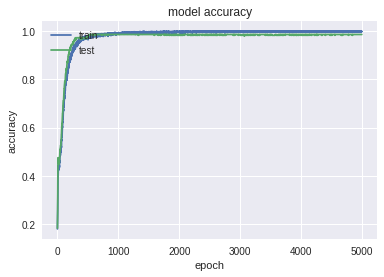

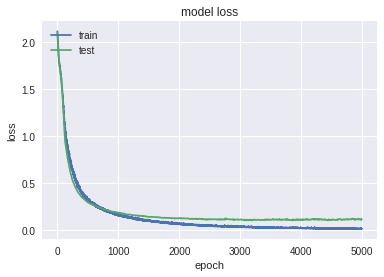

In [133]:

import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
example = tokenizer.texts_to_sequences(["What time does the train leave"])
example = pad_sequences(example, maxlen=MAX_SEQUENCE_LENGTH)

In [23]:
le.inverse_transform(np.argmax(model.predict(example)))

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


'when'

In [0]:
#Inference

-> deep learning algorithms clearly outperform statistical algorithms
-> LSTMs are better in caputuring sequential features that others cannot.
-> It is more expensive to calculate the network output and apply back propagation. You simply have more math to do because of the complex activation.
-> 

,question,type
0,how did serfdom develop in and then leave russia,unknown
1,what films featured the character popeye doyle,what
2,how can i find a list of celebrities real names,unknown
3,what fowl grabs the spotlight after the chines...,what
4,what is the full form of com,what
